In [1]:
##import nltk
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
import tensorflow
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pickle

##nltk.download("wordnet")
##nltk.download("stopwords")
##nltk.download("punkt")
##nltk.download("omw-1.4")

In [2]:
df = pd.read_csv("data.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [4]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [5]:
len(df) - len(df.drop_duplicates())

415

In [6]:
df.drop_duplicates(inplace = True)

<AxesSubplot:ylabel='Category'>

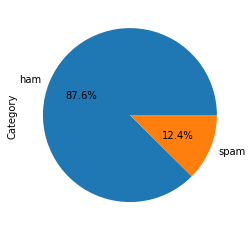

In [7]:
ratio_spam_and_ham = df["Category"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%')

Featured words in spam messeges:


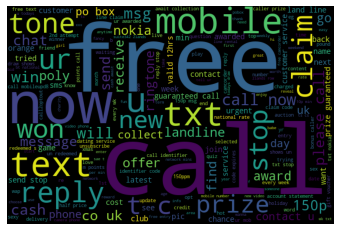

Featured words in non-spam messeges:


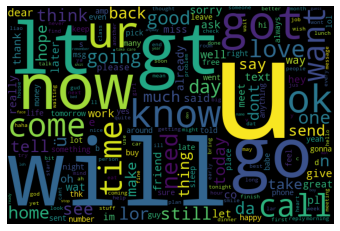

In [8]:
from wordcloud import WordCloud
def visualize(label):
    words=''
    for msg in df[df['Category'] == label]['Message']:
        msg = msg.lower()
        words+=msg + ''
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Featured words in spam messeges:")
visualize('spam')

print("Featured words in non-spam messeges:")
visualize('ham')

In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

In [10]:
df["Message"] = df.Message.map(preprocess) 

In [11]:
MAX_NB_WORDS = 3000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7071 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5157, 300)


In [13]:
Y = pd.get_dummies(df['Category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5157, 2)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3867, 300) (3867, 2)
(1290, 300) (1290, 2)


In [15]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
49/49 [==============================] - 23s 432ms/step - loss: 0.3879 - accuracy: 0.8739 - val_loss: 0.2111 - val_accuracy: 0.9096
Epoch 2/5
49/49 [==============================] - 23s 461ms/step - loss: 0.1121 - accuracy: 0.9703 - val_loss: 0.0703 - val_accuracy: 0.9767
Epoch 3/5
49/49 [==============================] - 23s 472ms/step - loss: 0.0433 - accuracy: 0.9893 - val_loss: 0.0560 - val_accuracy: 0.9806
Epoch 4/5
49/49 [==============================] - 24s 481ms/step - loss: 0.0266 - accuracy: 0.9926 - val_loss: 0.0683 - val_accuracy: 0.9755
Epoch 5/5
49/49 [==============================] - 24s 490ms/step - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.0738 - val_accuracy: 0.9780


In [18]:
print(history.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          300000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 380,602
Trainable params: 380,602
Non-trainable params: 0
_________________________________________________________________
None


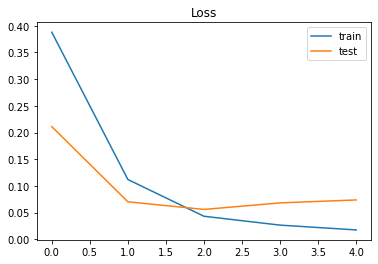

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

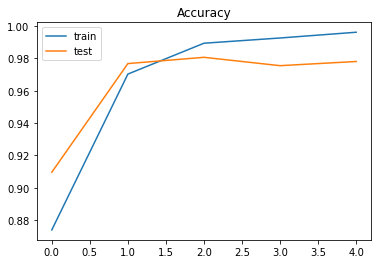

In [20]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [23]:
predictions = model.predict(X_test)

In [24]:
eval_results = []
for i in range(0,len(predictions)):
    eval_results.append(int(np.argmax(predictions[i])))

In [25]:
Y_test_true = []
for i in range(0,len(Y_test)):
    if(Y_test[i][0] == 0):
        Y_test_true.append(1)
    else:
        Y_test_true.append(0)

In [26]:
from sklearn.metrics import classification_report
target_names = ['ham','spam']
print(classification_report(Y_test_true, eval_results, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1124
        spam       0.92      0.94      0.93       166

    accuracy                           0.98      1290
   macro avg       0.95      0.96      0.96      1290
weighted avg       0.98      0.98      0.98      1290



In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_true, eval_results)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

,ham,spam
ham,1110,14
spam,10,156


AUC: 0.9636517600651718


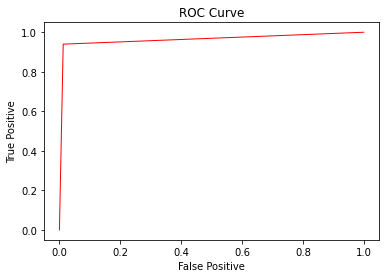

In [40]:
from sklearn import metrics
print("AUC:",metrics.roc_auc_score(Y_test_true, eval_results))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test_true, eval_results,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

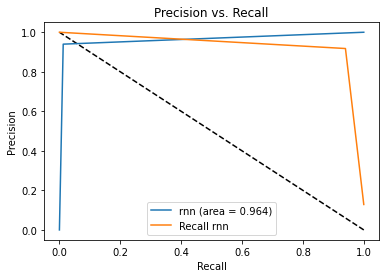

In [41]:
fpr_en, tpr_en, thresholds_en = metrics.roc_curve(Y_test_true, eval_results)
roc_auc_en = metrics.auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = metrics.precision_recall_curve(Y_test_true, eval_results)
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(fpr_en, tpr_en, label='rnn (area = %0.3f)' % roc_auc_en)
plt.plot(recall_en,precision_en , label='Recall rnn')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

In [42]:
model.save("Final Model.h5")

In [45]:
from keras.models import load_model
loadedModel = load_model("Final Model.h5")
testText = str(input("Please , Enter Message\n"))
testText = preprocess(testText)
testText = [testText]
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
testText = tokenizer.texts_to_sequences(testText)
testText = pad_sequences(testText, maxlen=MAX_SEQUENCE_LENGTH)
pred = loadedModel.predict(testText)
eval_results = []
for i in range(0,len(pred)):
    eval_results.append(int(np.argmax(pred[i])))
if eval_results[0] == 1:
    print("Spam")
elif eval_results[0] == 0:
    print("Ham")

Please , Enter Message
Congratulations! You’ve won a $1,000 Walmart gift card. Go to www.bit.ly/bbkk2345.com to claim your prize
Spam
